<a id="import"></a>
## <center>Import required modules</center>

In [1]:
import pandas as pd
import numpy as np
from numpy import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import albumentations as A
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

2024-04-11 07:45:25.311055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 07:45:25.311160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 07:45:25.574206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="makedf"></a>
## <center>Make a  df dataframe and a val dataframe of the form [filepaths, labels]</center>

In [2]:
limiter=300
data_path=r'/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/'
classes=os.listdir(data_path)
filepaths=[]
labels=[]
for klass in classes:
    classpath=os.path.join(data_path, klass)
    flist=os.listdir(classpath)
    if len(flist) > limiter:
        flist=np.random.choice(flist, limiter, replace=False)
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
num_of_classes=len(classes)


<a id="makettv"></a>
## <center>Make train, test and valid dataframes from df</center>

In [3]:
'''partition df into a train set with 80% of the images, a test set with 10% of the images and a vaslidation set with 10% of the images'''
train_df, dummy_df=train_test_split(df, train_size=.8, random_state=123, shuffle=True, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, random_state=123, shuffle=True, stratify=dummy_df['labels'])
print(f'test_df length= {len(test_df)}  train_df lngth= {len(train_df)}  valid_df length= {len(valid_df)}')
train_balance=train_df['labels'].value_counts()

print(f'the train_set contain {num_of_classes} class, the class balance is:\n {train_balance}')

test_df length= 120  train_df lngth= 960  valid_df length= 120
the train_set contain 4 class, the class balance is:
 labels
glioma        240
pituitary     240
meningioma    240
notumor       240
Name: count, dtype: int64


<a id="balance"></a>
## <center>Define a function to balance the dataframe to have a fixed number of images per class</center>

In [4]:
''' dataset is not balanced . 
Use agmentation to balance the dataset Define a function to balance the dataset'''
def balance(df, n,column, working_dir, img_size):    
    def get_augmented_image(image): # given an image this function returns an augmented image
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])    
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0    
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        msg=f'augmenting images in train set  for class {label}                                              '
        print(msg, '\r', end='')        
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images            
            desc=f'augmenting class {label:25s}'
            for i in range(delta):                
                j= i % sample_count # need this because we may have to go through the image list several times to get the needed number
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)                
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
        
    print('')
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))    
    return df 

In [5]:
img_size= (224,224)
n=500
column='labels'
working_dir=r'/kaggle/working/'
train_df=balance(train_df, n,column, working_dir, img_size)

Initial length of dataframe is  960
augmenting images in train set  for class notumor                                                  
Total Augmented images created=  1040
Length of augmented dataframe is now  2000


<a id="makegen"></a>
## <center>Make train, test and valid generators</center>

In [6]:
batch_size=50
ycol='labels'
gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)    
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,seed=123,
                                                                    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels   

Found 2000 validated image filenames belonging to 4 classes.           for train generator 
Found 120 validated image filenames belonging to 4 classes.            for valid generator 
Found 120 validated image filenames belonging to 4 classes.            for test generator 


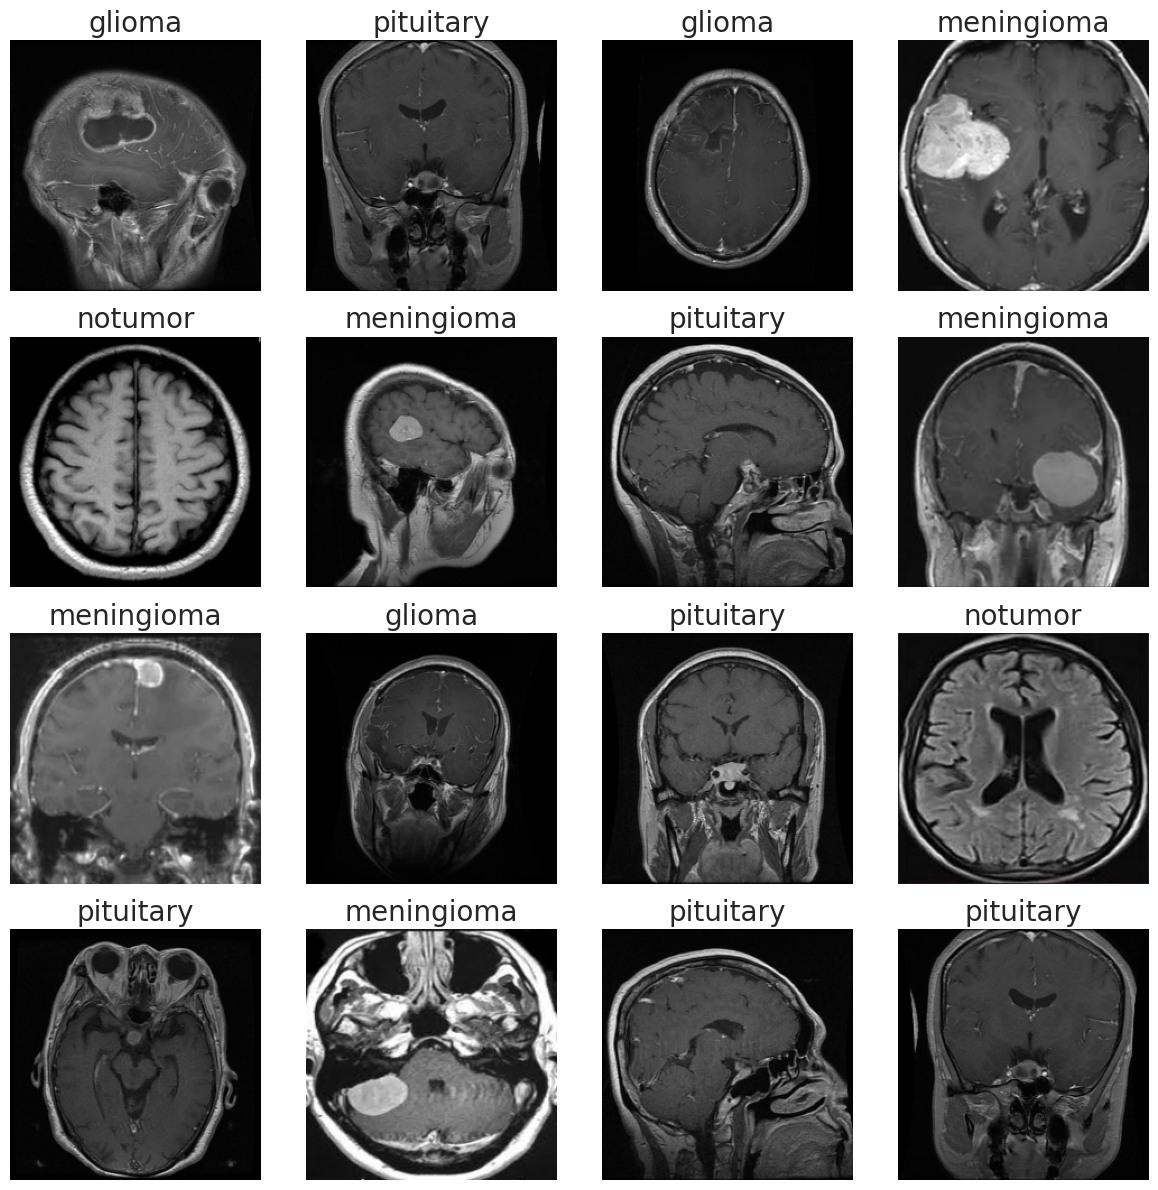

In [7]:
import matplotlib.pyplot as plt

def plot_augmented_images(df, img_size, save_path=None, title_fontsize=10):
    num_images = 16
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_images):
        img_path = df['filepaths'].iloc[i]
        label = df['labels'].iloc[i]

        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)

        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(label, fontsize=title_fontsize)
        axes[i].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Assuming train_df is the augmented dataframe returned from balance function
plot_augmented_images(train_df, img_size, save_path="/kaggle/working/augmented_images_plot.png", title_fontsize=20)


<a id="makef1"></a>
## <center>Define a function to generate F1 score metric</center>

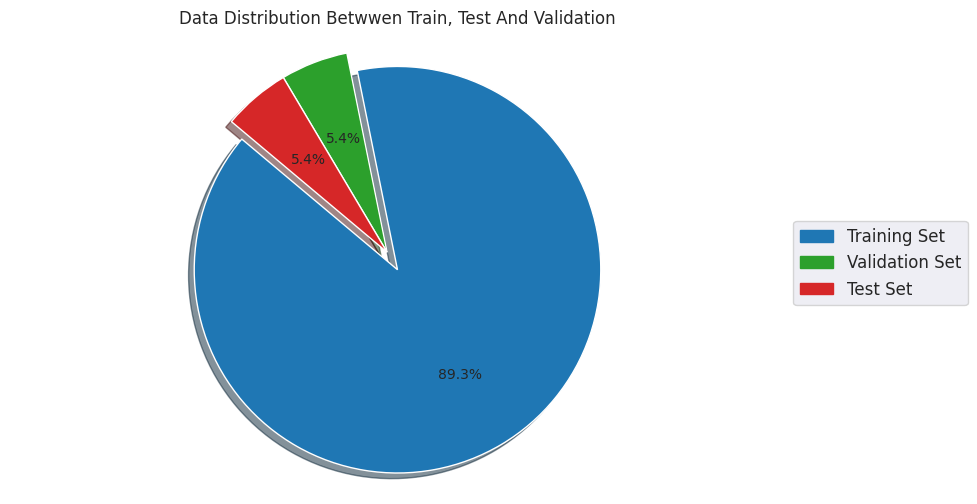

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Count samples in each set
train_samples = len(train_df)
valid_samples = len(valid_df)
test_samples = len(test_df)

# Define colors and labels
colors = ['#1f77b4', '#2ca02c', '#d62728']  # Darker colors
labels = ['Training Set', 'Validation Set', 'Test Set']
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

# Plotting the pie chart
sizes = [train_samples, valid_samples, test_samples]
explode = (0.1, 0, 0)  # explode the 1st slice (Training Set)

plt.figure(figsize=(10, 6))
plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data Distribution Betwwen Train, Test And Validation')

# Adding custom legend
plt.legend(handles=patches, loc="center left", fontsize='large', bbox_to_anchor=(1, 0.5))

# Save the plot as PNG
plt.savefig('data_distribution.png', bbox_inches='tight')

plt.show()


In [9]:
'''define a function to compute the F1_score metric'''
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<a id="model"></a>
## <center>Define a function to create a model</center>

In [25]:
'''create a function that can produce a specific model '''
def make_model(img_size, num_of_classes, lr, modnum):  
    img_shape=(img_size[0], img_size[1], 3)
    if modnum ==1:
        base_model=tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg= 'created MobileNet V2 model'
    elif modnum == 2:
        base_model=tf.keras.applications.DenseNet201(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='created DenseNet201 model'
    elif modnum == 3:        
        base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetB3 model'         
    elif modnum == 4:
        base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNetB4 model'
    elif modnum == 5:        
        base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created InceptionResNetV2 model' 
    elif modnum == 6:        
        base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created ResNet50 model'
    elif modnum == 7:        
        base_model=tf.keras.applications.ResNet152(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created ResNet152 model'
    elif modnum == 8:        
        base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created VGG16 model'
    elif modnum == 9:        
        base_model=tf.keras.applications.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created VGG19 model'
    else:
        print("fuck you")
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(num_of_classes, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score]) 
    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    return model


In [26]:
model_num=9  # will create an EfficientNetB0 model
lr=.001 # set initial learning rate
model=make_model(img_size, num_of_classes, lr, model_num)

80134624/80134624 [==============================] - 0s 0us/step
Created VGG19 model with initial learning rate set to 0.001


In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [28]:
from contextlib import redirect_stdout

# Assuming your model is named 'model'
with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()


<a id="callbacks"></a>
## <center>Define callbacks</center>

In [29]:
'''define callbacks -Reduce Learning rate on plateau and early stopping'''
rlronp=keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.4, patience=2, verbose=1, mode="auto",  min_delta=0.00001, cooldown=0, min_lr=0.0)
estop=keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,  patience=2, verbose=1, mode="auto", baseline=None, restore_best_weights=True)
callbacks=[rlronp, estop]

<a id="train"></a>
## <center>Train the Model</center>

In [30]:
epochs=25
initial_epoch=0
history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
                   validation_steps=None,  shuffle=True,  initial_epoch=initial_epoch) # train the model

Epoch 1/25
40/40 [==============================] - 78s 997ms/step - loss: 6.6891 - accuracy: 0.4970 - F1_score: 0.4188 - val_loss: 16.7482 - val_accuracy: 0.2500 - val_F1_score: 0.2600 - lr: 0.0010
Epoch 2/25
40/40 [==============================] - 33s 812ms/step - loss: 5.5122 - accuracy: 0.5960 - F1_score: 0.5099 - val_loss: 6.9542 - val_accuracy: 0.3167 - val_F1_score: 0.3771 - lr: 0.0010
Epoch 3/25
40/40 [==============================] - 33s 814ms/step - loss: 4.8475 - accuracy: 0.6325 - F1_score: 0.5648 - val_loss: 4.9328 - val_accuracy: 0.5417 - val_F1_score: 0.4422 - lr: 0.0010
Epoch 4/25
40/40 [==============================] - 33s 813ms/step - loss: 4.3514 - accuracy: 0.6520 - F1_score: 0.5800 - val_loss: 4.4346 - val_accuracy: 0.5833 - val_F1_score: 0.5422 - lr: 0.0010
Epoch 5/25
40/40 [==============================] - 33s 813ms/step - loss: 3.9092 - accuracy: 0.6875 - F1_score: 0.6388 - val_loss: 3.9486 - val_accuracy: 0.6250 - val_F1_score: 0.6259 - lr: 0.0010
Epoch 6/2

In [31]:
model.save("VGG19.h5")

<a id="plottr"></a>
## <center>Define a function to plot the training data</center>

In [32]:
'''Define a function to plot the training data'''
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    index_f1=np.argmax(vf1)
    vf1_highest=vf1[index_f1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_f1 + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

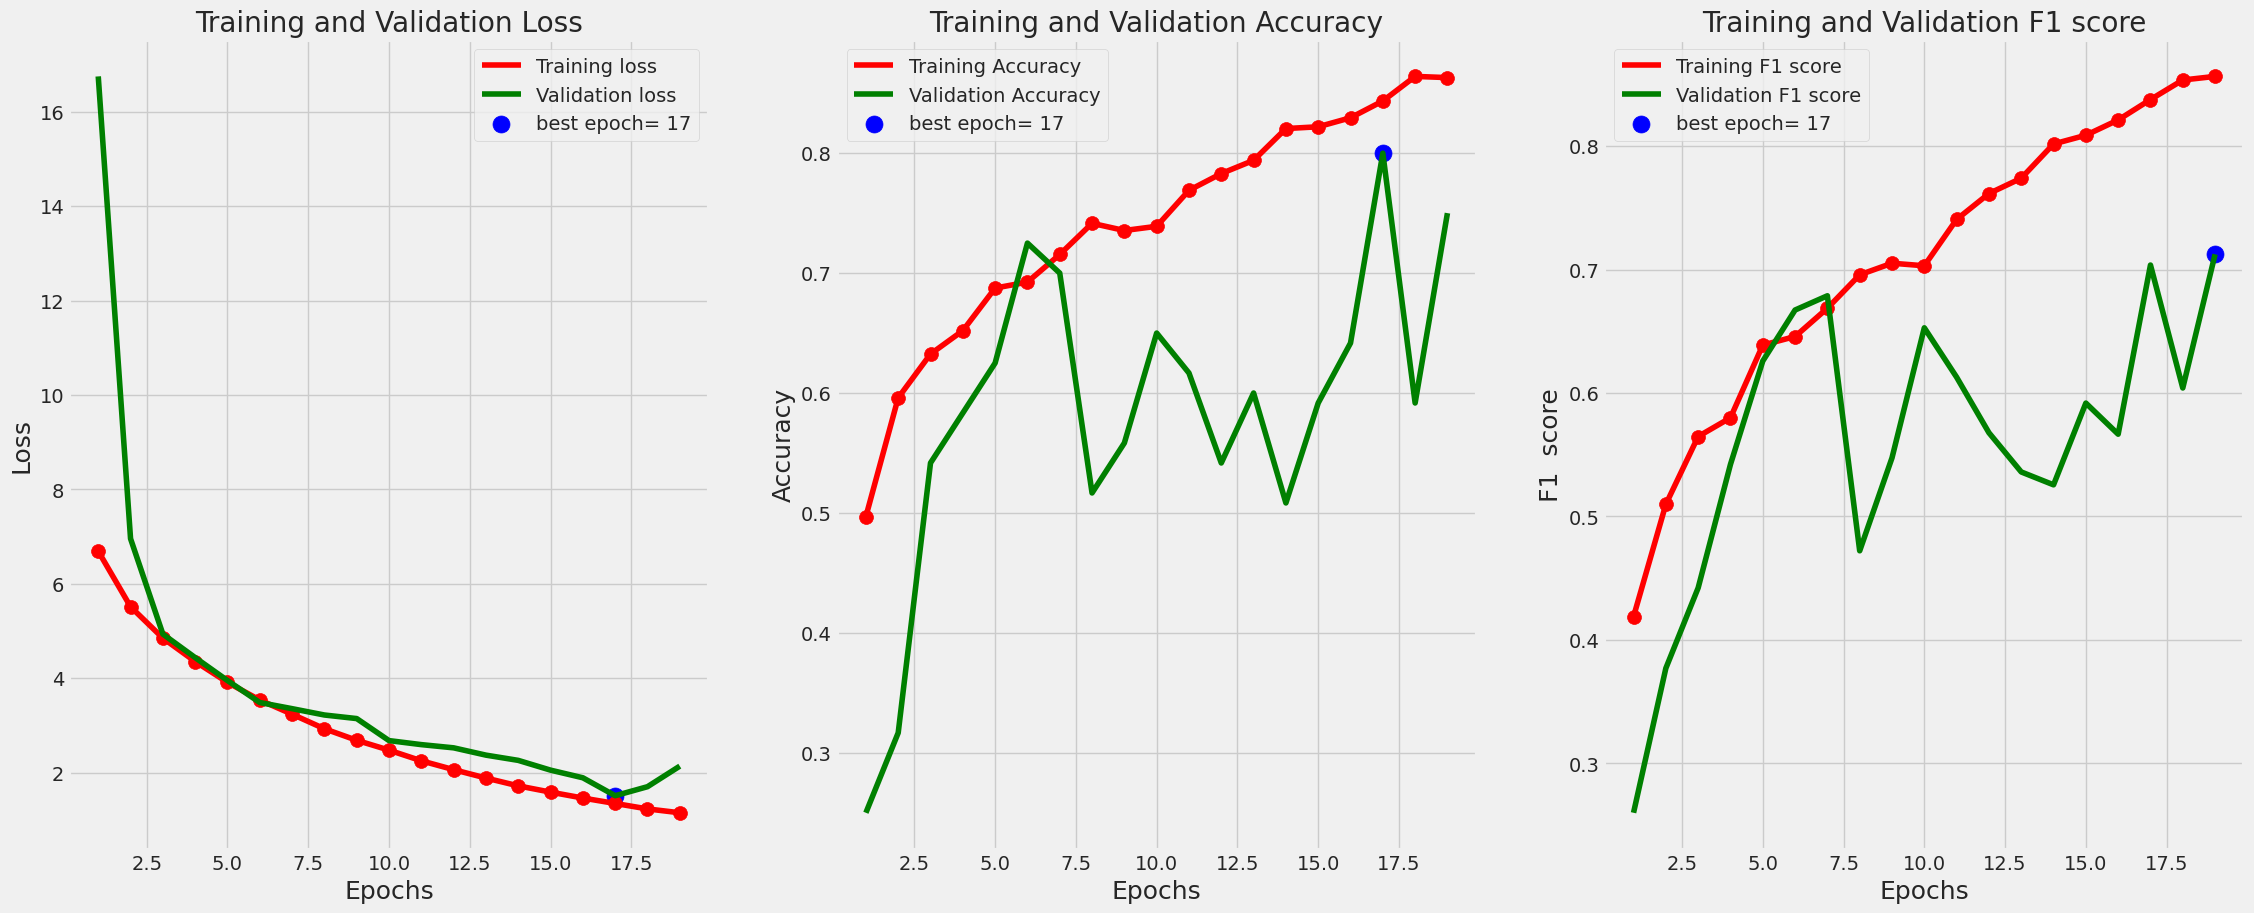

In [33]:
tr_plot(history) # plot the training data

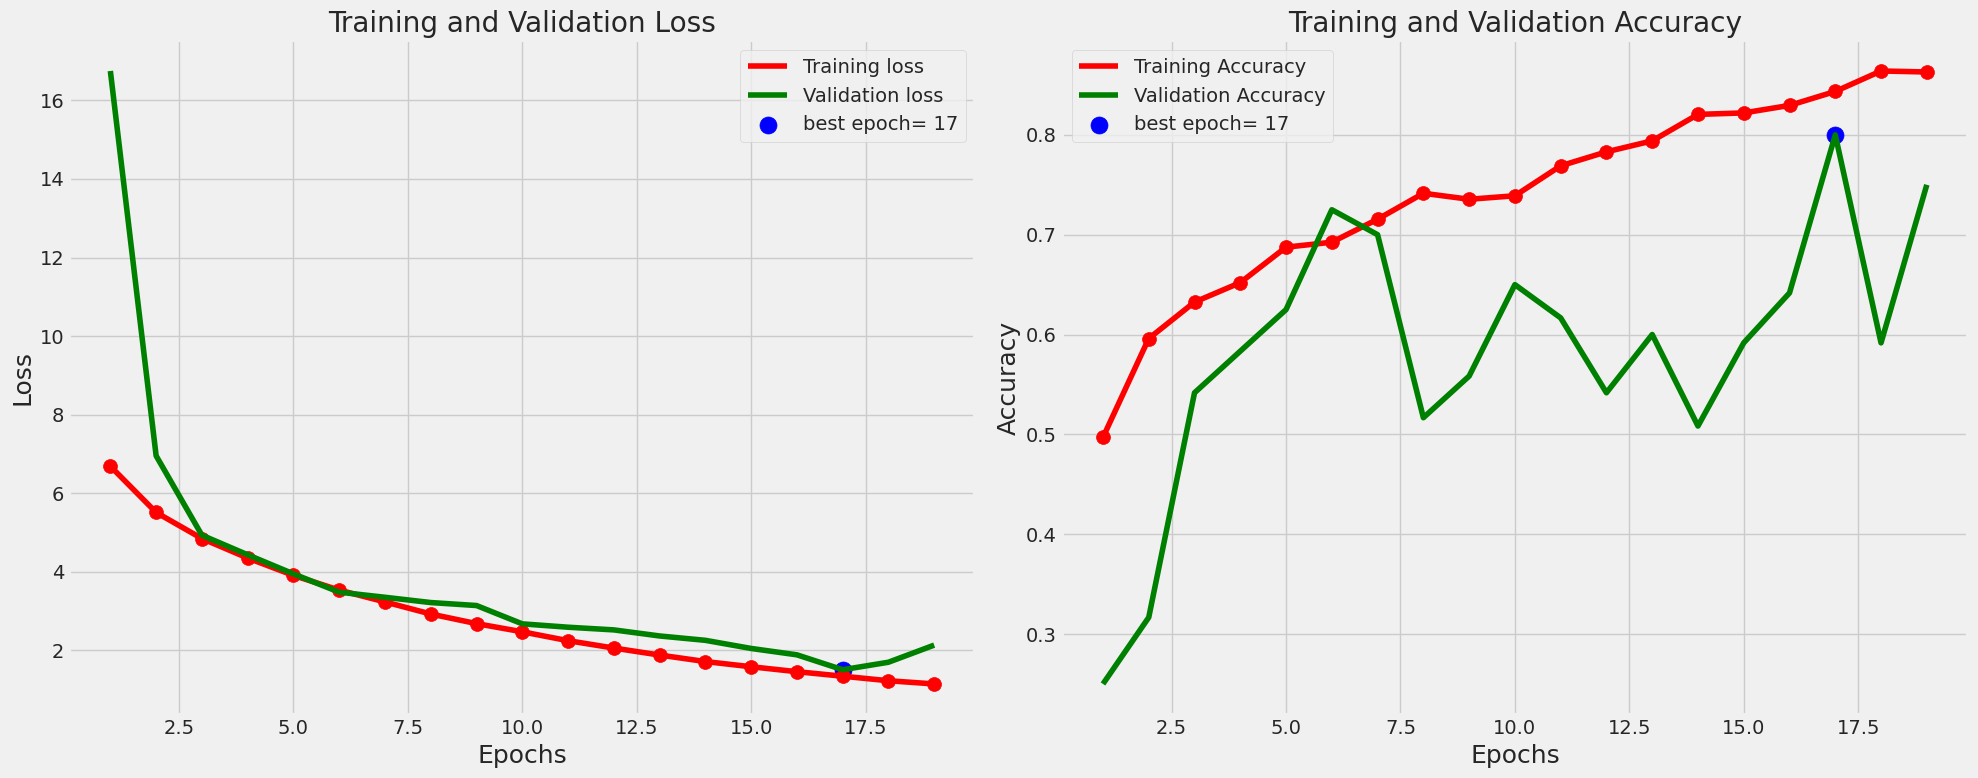

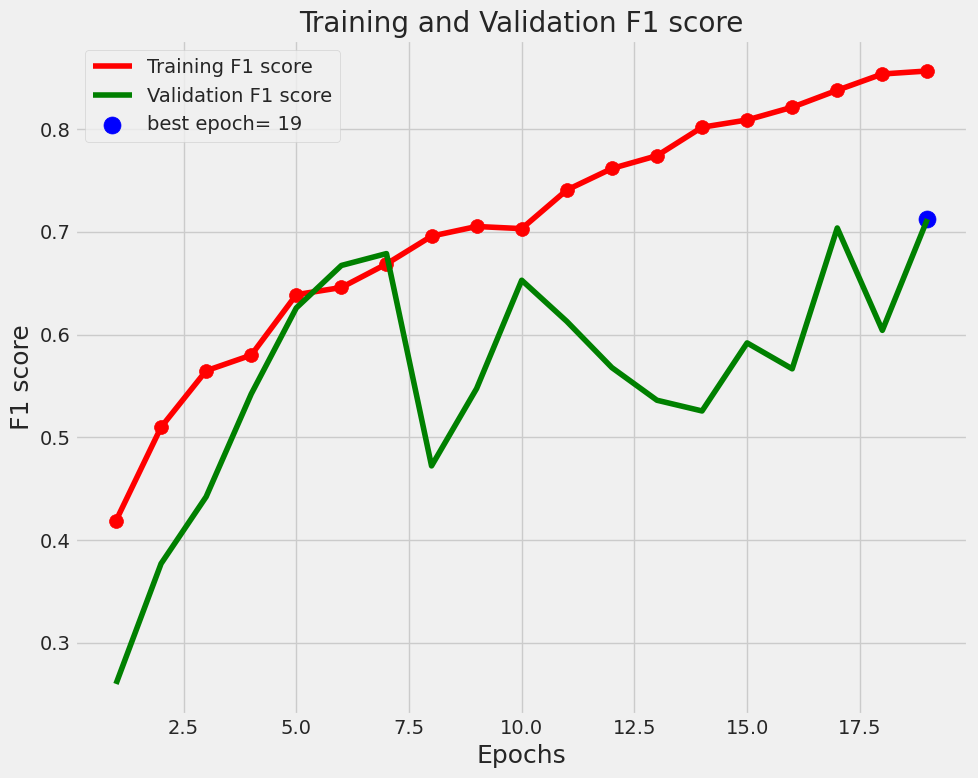

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def tr_plot(tr_data, save_path=None):
    start_epoch = 0
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    tf1 = tr_data.history['F1_score']
    vf1 = tr_data.history['val_F1_score']    
    Epoch_count = len(tacc) + start_epoch
    
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)   
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    index_f1 = np.argmax(vf1)
    vf1_highest = vf1[index_f1]
    
    plt.style.use('fivethirtyeight')
    
    # Plotting Loss and Accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    # Plot Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss' )
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label='best epoch= ' + str(index_loss + 1 + start_epoch))
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    
    # Plot Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label='best epoch= ' + str(index_acc + 1 + start_epoch))
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path + "_loss_acc.png", dpi=300)
        plt.savefig(save_path + "_loss_acc.svg")
    plt.show()
    
    # Plotting F1 score
    plt.figure(figsize=(10, 8))
    plt.plot(Epochs, tf1, 'r', label='Training F1 score')    
    plt.plot(Epochs, vf1, 'g', label='Validation F1 score')
    index_tf1 = np.argmax(tf1)  # this is the epoch with the highest training F1 score
    tf1max = tf1[index_tf1]
    index_vf1 = np.argmax(vf1)  # this is the epoch with the highest validation F1 score
    vf1max = vf1[index_vf1]
    plt.scatter(index_vf1 + 1 + start_epoch, vf1max, s=150, c='blue', label='best epoch= ' + str(index_vf1 + 1 + start_epoch))    
    plt.scatter(Epochs, tf1, s=100, c='red')
    plt.title('Training and Validation F1 score')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('F1 score', fontsize=18)
    plt.legend()    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path + "_f1_score.png", dpi=300)
        plt.savefig(save_path + "_f1_score.svg")
    plt.show()

tr_plot(history, save_path="training_plot")


<a id="pred"></a>
## <center>Define a function to do predictions on test set</center>

In [35]:
'''Define a function that makes predictions on the test set'''
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    pred_indices=[]
    test_count =len(preds)    
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1 
    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels, dtype='int')
    ypred=np.array(pred_indices, dtype='int')
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg)
    cm = confusion_matrix(ytrue, ypred )
    # plot the confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return 

2/2 [==============================] - 16s 35ms/step
There were 22 errors in 120 tests for an accuracy of  81.67 and an F1 score of  79.68


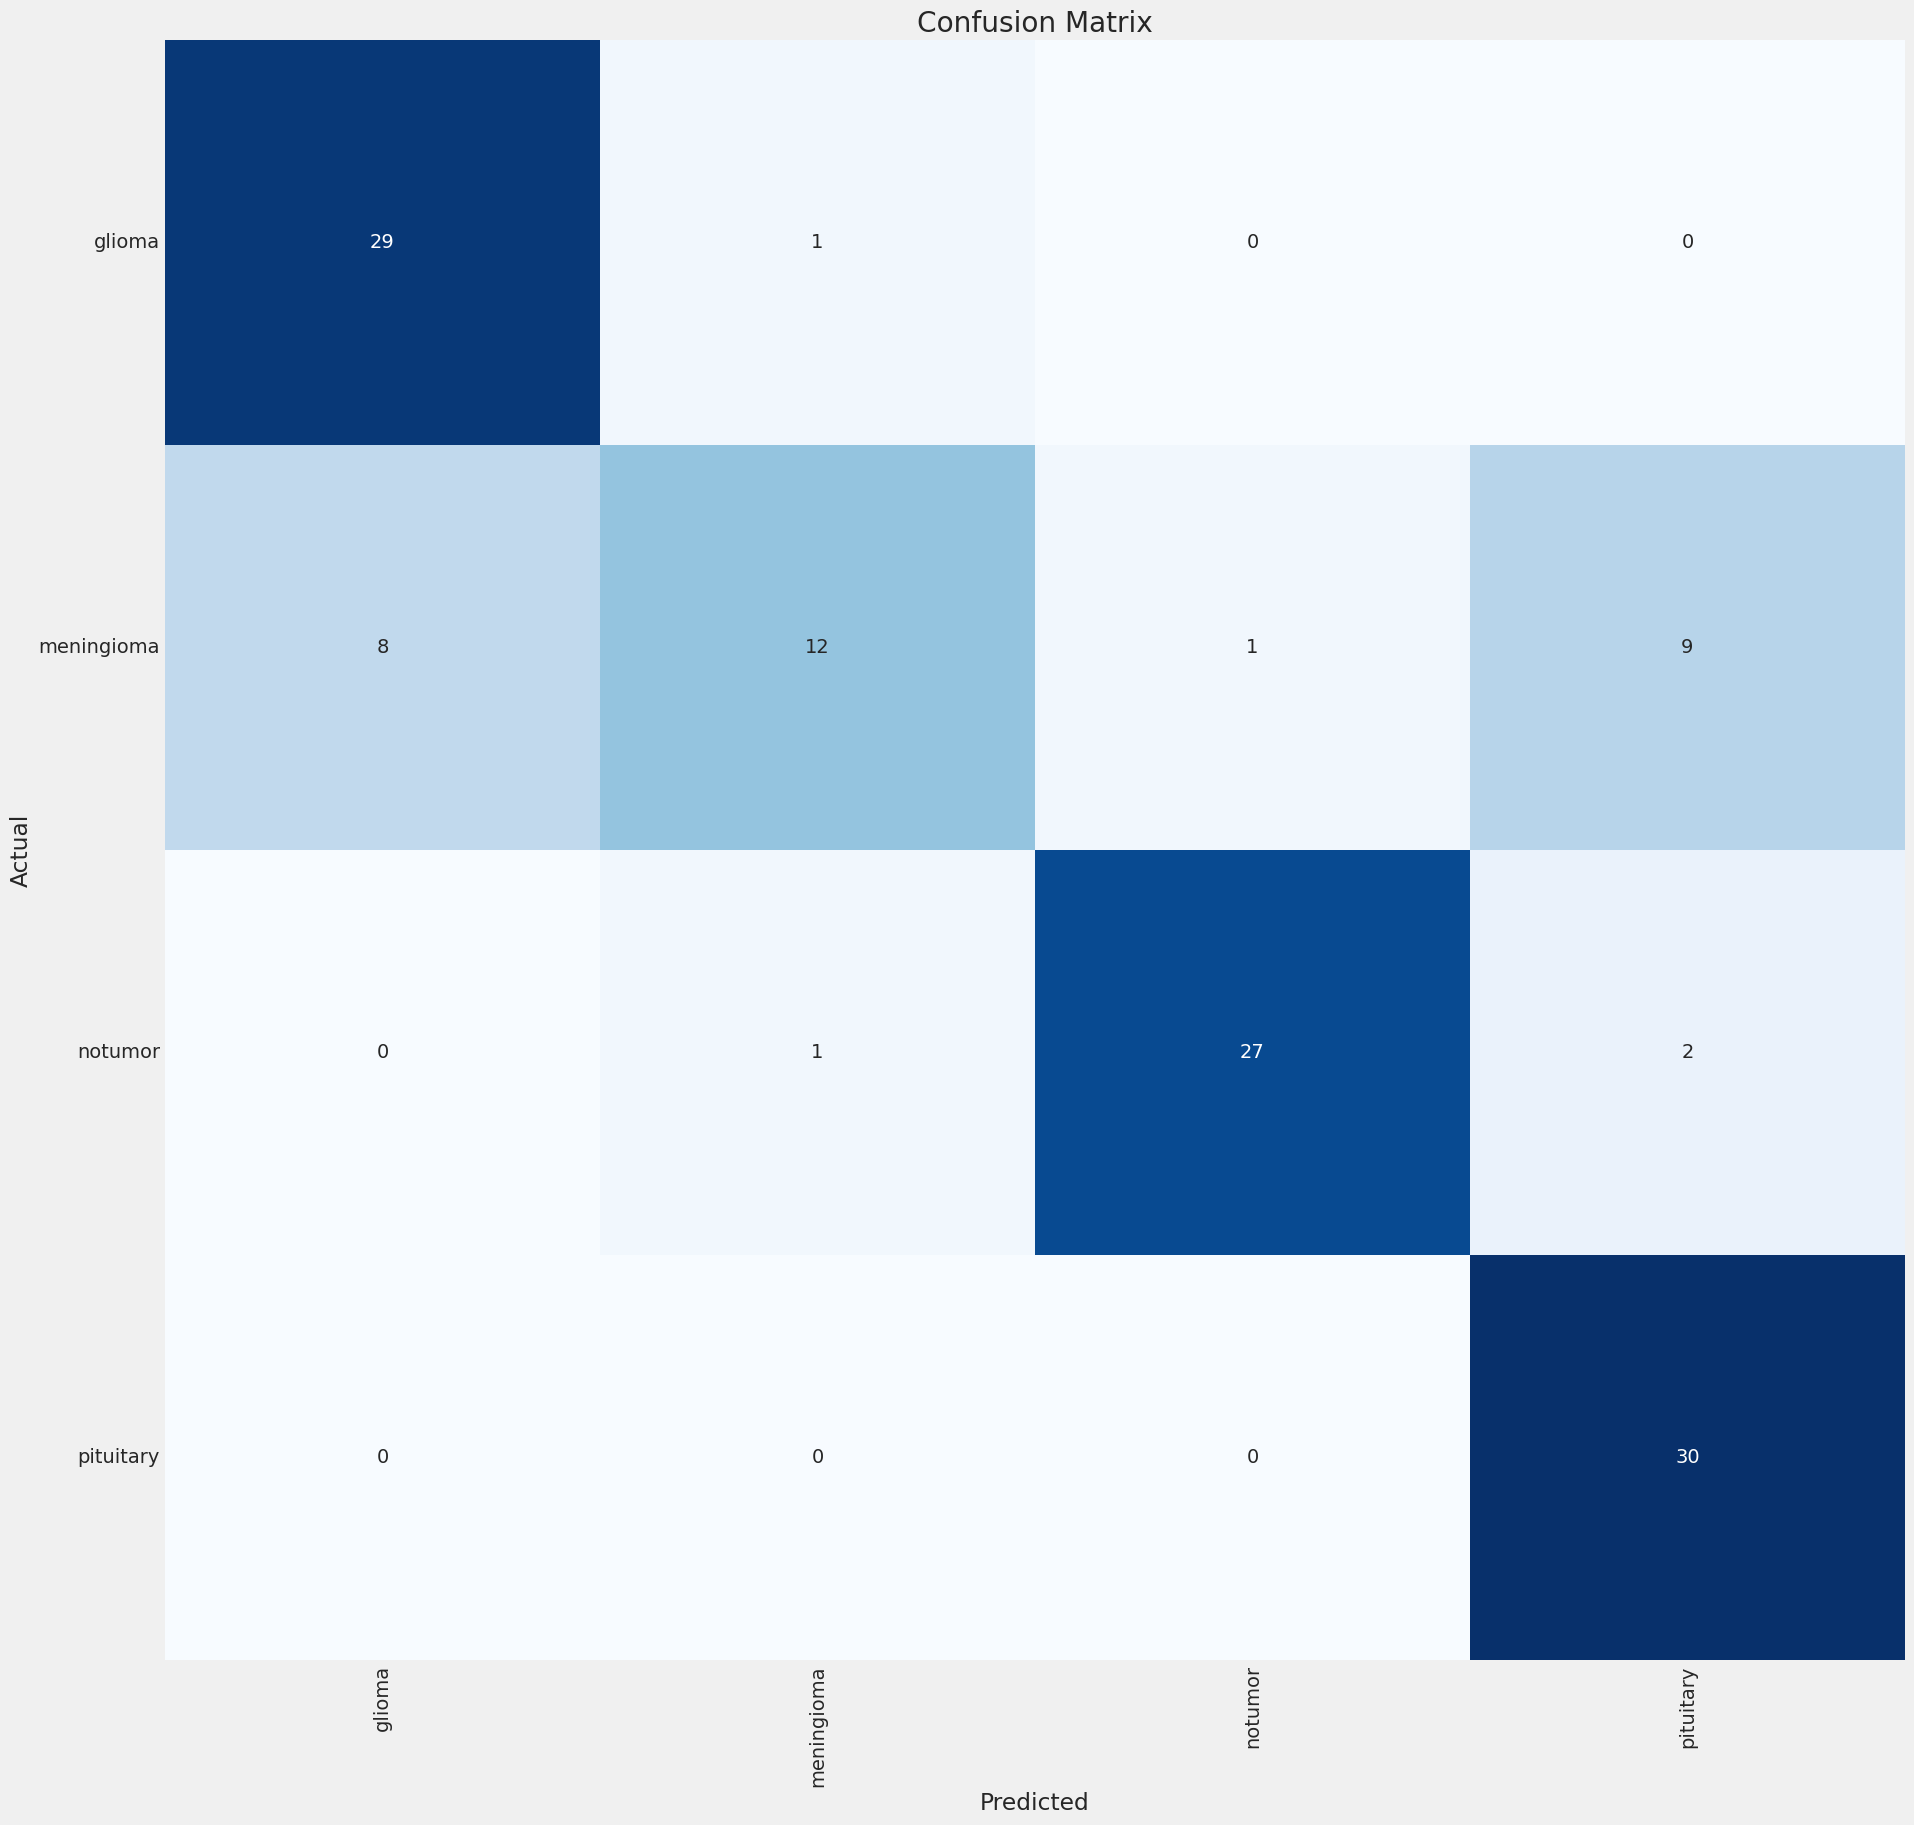

Classification Report:
----------------------
               precision    recall  f1-score   support

      glioma     0.7838    0.9667    0.8657        30
  meningioma     0.8571    0.4000    0.5455        30
     notumor     0.9643    0.9000    0.9310        30
   pituitary     0.7317    1.0000    0.8451        30

    accuracy                         0.8167       120
   macro avg     0.8342    0.8167    0.7968       120
weighted avg     0.8342    0.8167    0.7968       120



In [36]:
predictor(model,test_gen) # make predictions on test set

2/2 [==============================] - 1s 262ms/step
There were 22 errors in 120 tests for an accuracy of  81.67 and an F1 score of  79.68


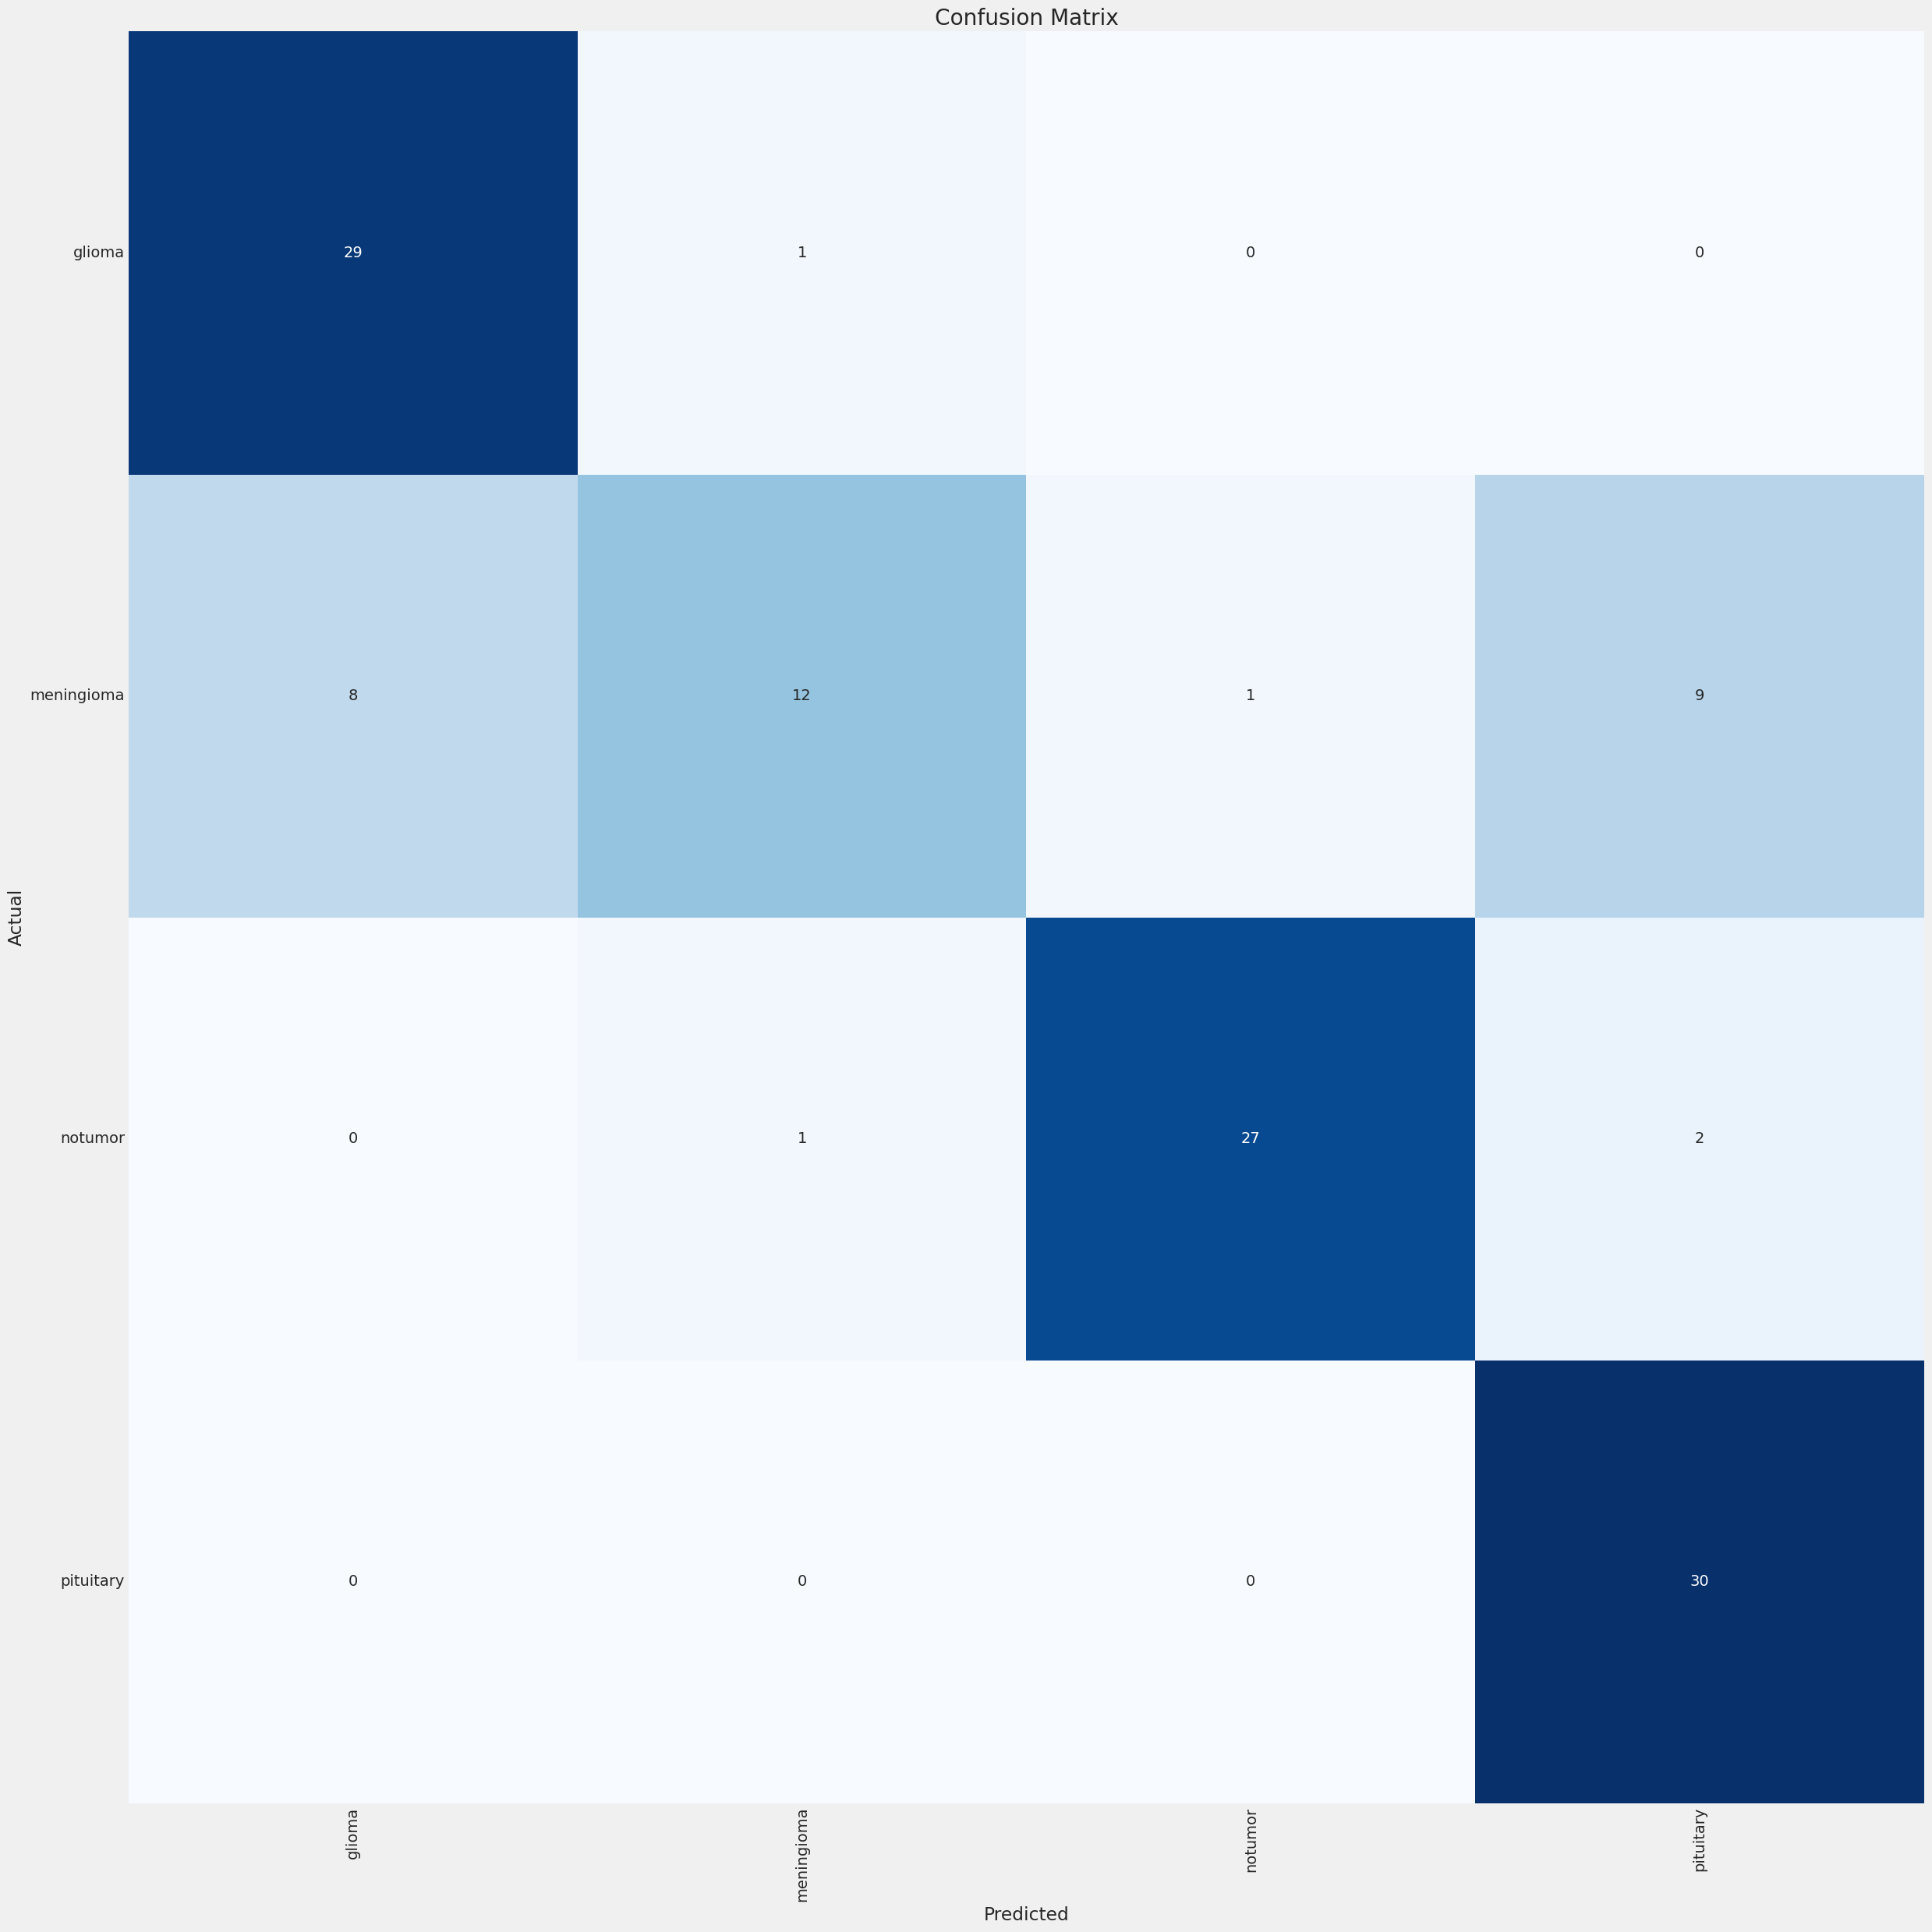

Classification Report:
----------------------
               precision    recall  f1-score   support

      glioma     0.7838    0.9667    0.8657        30
  meningioma     0.8571    0.4000    0.5455        30
     notumor     0.9643    0.9000    0.9310        30
   pituitary     0.7317    1.0000    0.8451        30

    accuracy                         0.8167       120
   macro avg     0.8342    0.8167    0.7968       120
weighted avg     0.8342    0.8167    0.7968       120



In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, f1_score

def predictor(model, test_gen):
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    preds = model.predict(test_gen, verbose=1)
    errors = 0
    pred_indices = []
    test_count = len(preds)    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        pred_indices.append(pred_index)
        true_index = test_gen.labels[i]    
        if  pred_index != true_index:        
            errors += 1 
    
    accuracy = (test_count - errors) * 100 / test_count
    ytrue = np.array(test_gen.labels, dtype='int')
    ypred = np.array(pred_indices, dtype='int')
    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    cm = confusion_matrix(ytrue, ypred)
    clr = classification_report(ytrue, ypred, target_names=classes, digits=4, output_dict=True)

    # Save results to CSV
    results_dict = {
        "Accuracy": [accuracy],
        "F1 Score": [f1score],
        "Errors": [errors],
        "Total Tests": [test_count]
    }
    results_df = pd.DataFrame(results_dict)
    results_df.to_csv("results.csv", index=False)

    # Save classification report to CSV
    clr_df = pd.DataFrame(clr)
    clr_df.to_csv("Classification_report.csv")

    # Save confusion matrix to CSV
    cm_df = pd.DataFrame(cm, columns=classes, index=classes)
    cm_df.to_csv("confusion_matrix.csv")

    # Save LaTeX table for confusion matrix
    with open("confusion_matrix.tex", "w") as f:
        f.write(cm_df.to_latex())

    # Save LaTeX table for classification report
    with open("classification_report.tex", "w") as f:
        f.write(clr_df.to_latex())

    # Print metrics
    msg = f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print(msg)

    # Plot confusion matrix
    plt.figure(figsize=(25, 25))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()  # Adjust layout to prevent cutting off parts
    plt.savefig("confusion_matrix.png", bbox_inches='tight')  # Save with tight bounding box
    plt.show()

    # Print and save classification report
    print("Classification Report:\n----------------------\n", classification_report(ytrue, ypred, target_names=classes, digits=4))
    with open("classification_report.txt", "w") as f:
        f.write(classification_report(ytrue, ypred, target_names=classes, digits=4))

    return accuracy, f1score

accuracy, f1score = predictor(model, test_gen)


2/2 [==============================] - 1s 308ms/step
There were 22 errors in 120 tests for an accuracy of  81.67 and an F1 score of  79.68


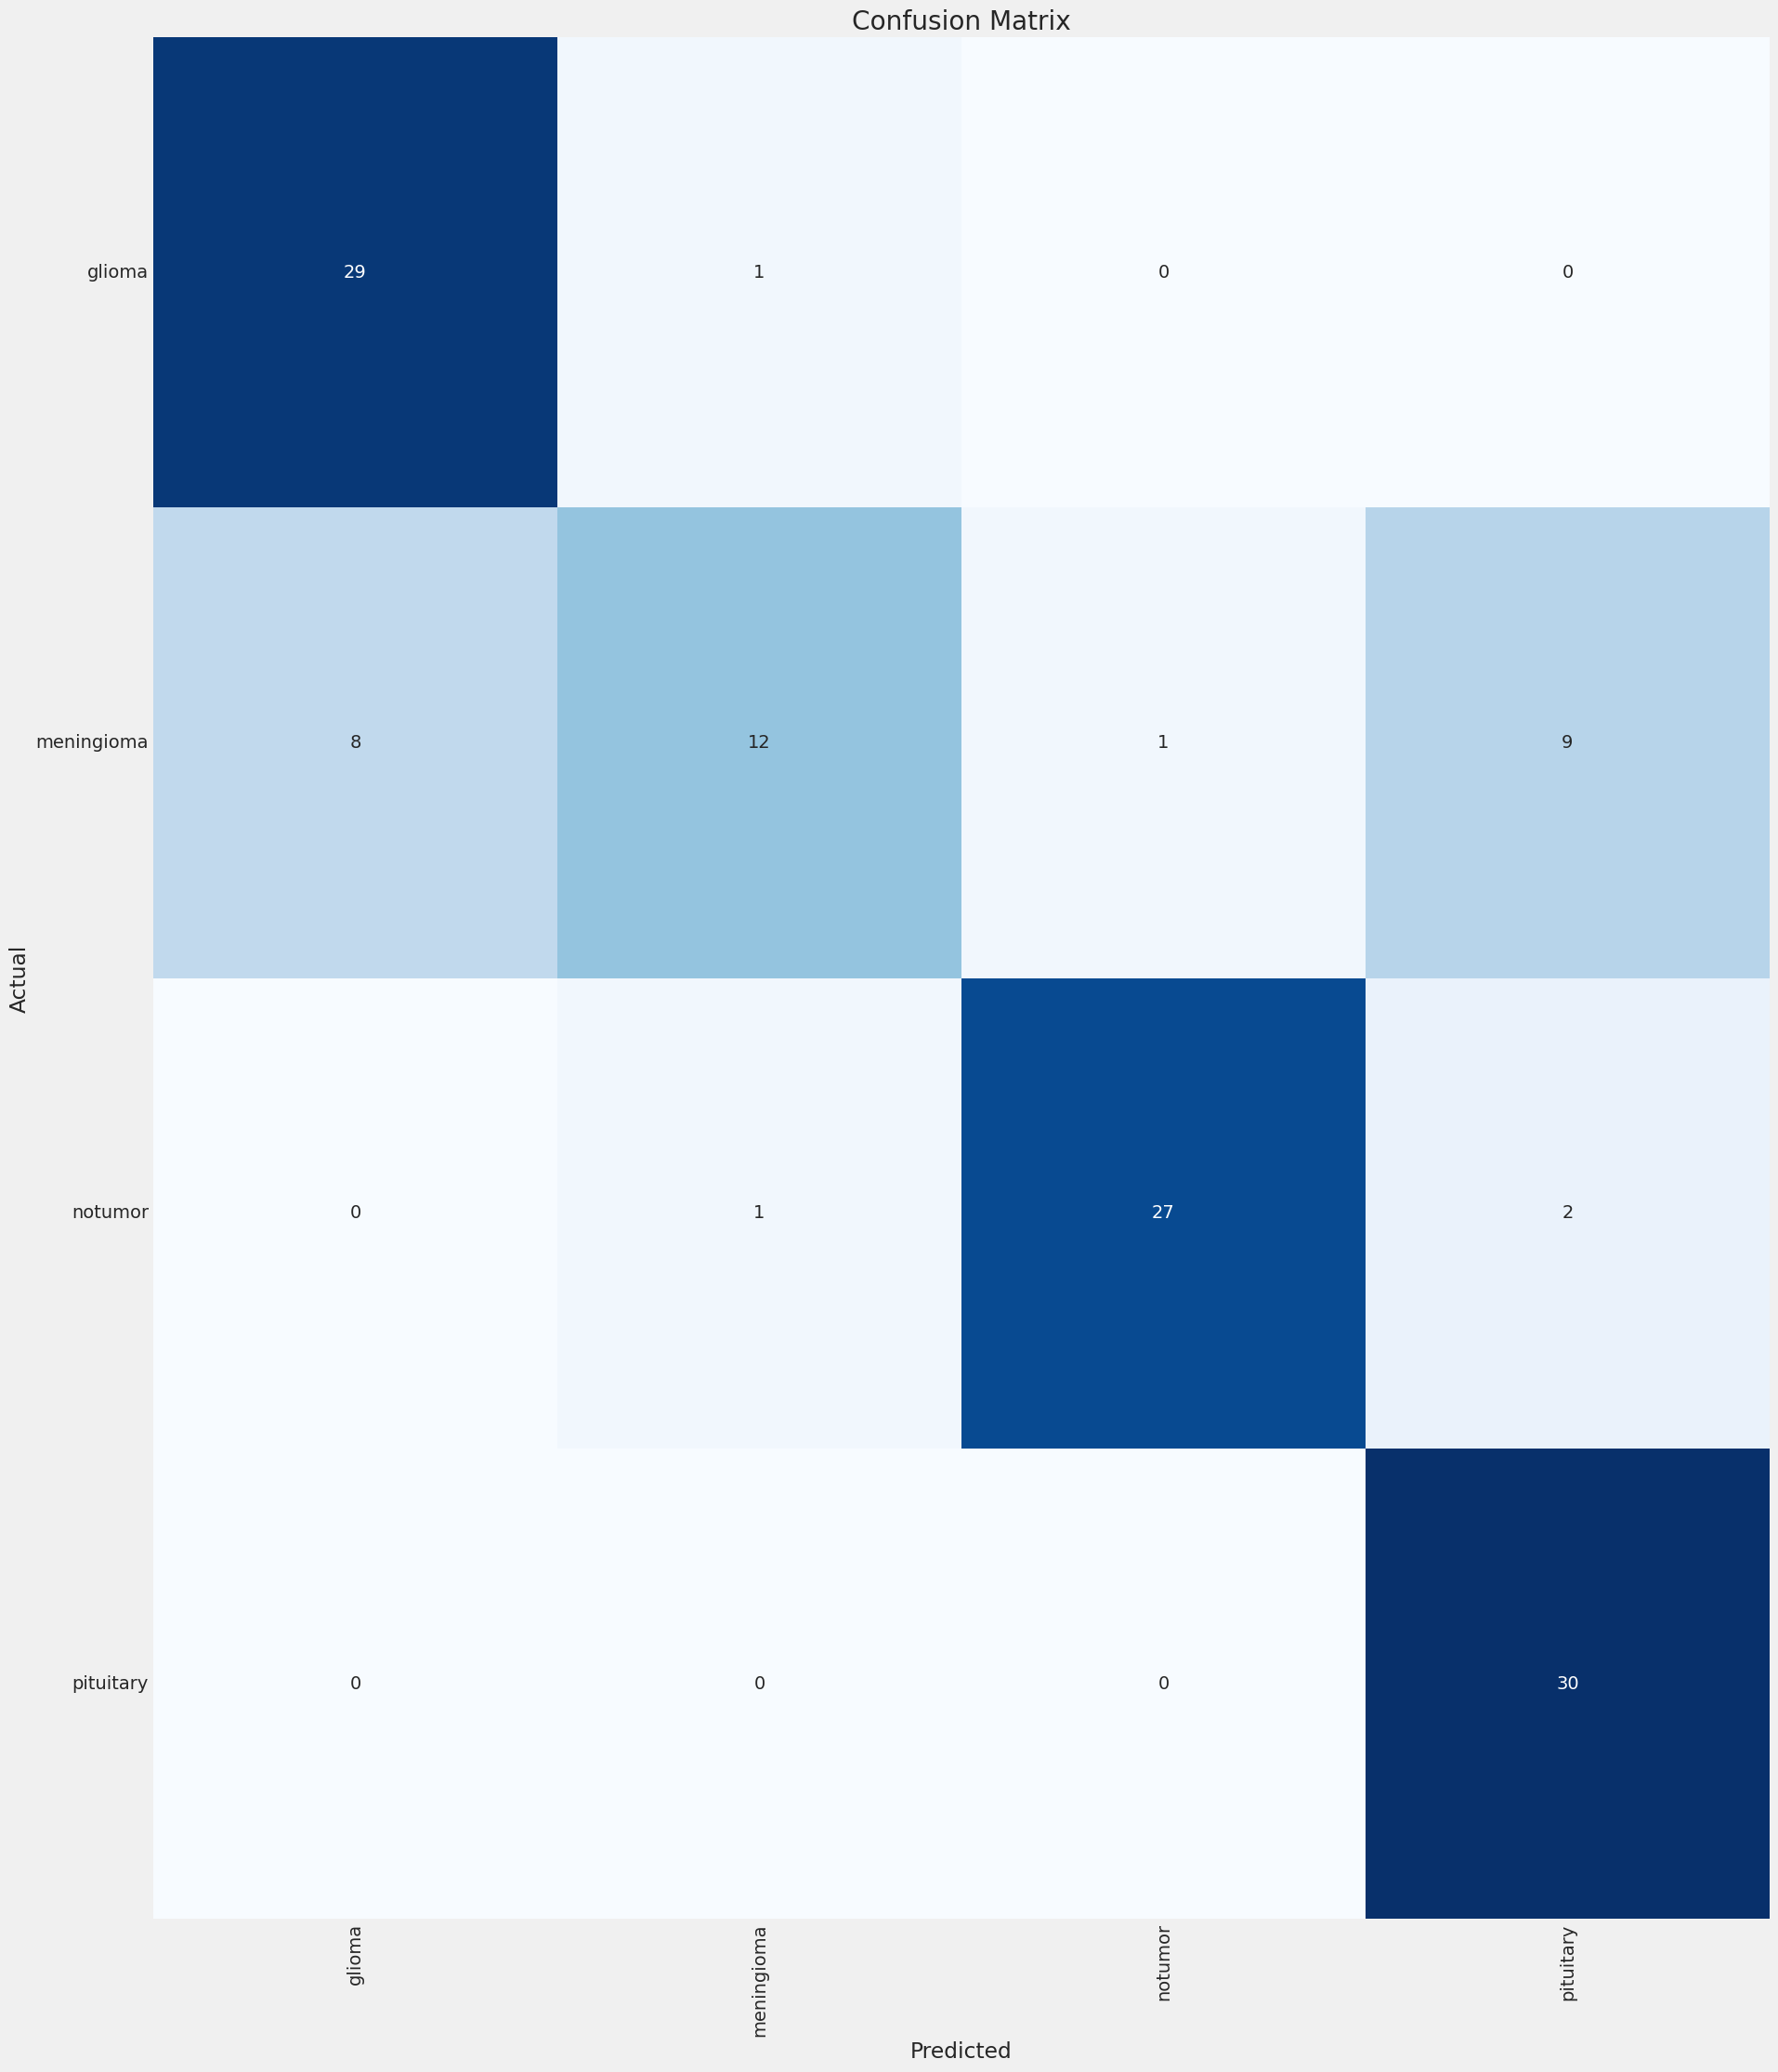

Classification report saved to classification_report.csv


In [39]:
import pandas as pd

def predictor(model, test_gen, save_csv=False, csv_filename=None):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    pred_indices=[]
    test_count =len(preds)    
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1 
    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels, dtype='int')
    ypred=np.array(pred_indices, dtype='int')
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg)
    cm = confusion_matrix(ytrue, ypred )
    # plot the confusion matrix
    plt.figure(figsize=(20, 25))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    clr = classification_report(ytrue, ypred, target_names=classes, digits=4, output_dict=True)
    clr_df = pd.DataFrame(clr).transpose()
    
    if save_csv:
        if csv_filename is None:
            csv_filename = "classification_report.csv"
        clr_df.to_csv(csv_filename)
        print(f"Classification report saved to {csv_filename}")
    
    return clr_df

# Call the function with saving to CSV enabled
classification_report_df = predictor(model, test_gen, save_csv=True, csv_filename="classification_report.csv")


<a id="mnet"></a>
## <center>Train and Predict using MobileNetV3 large Model</center>

<a id="discuss"></a>
## <center>Discussion of Results</center>

#### The number of images used per class was limited to 250 images in order to reduce training time.  Augmentation was used to balance the training set so that each class had 200 image files. Both models were run for 15 epochs. The EfficientNetB0 model achieved an F1 score of 93.48 % with anaverage time per epoch of 79 seconds. The MobileNetV3 large model achied an F1 score of 93.23 % with an average time per epoch of 59 seconds. Both models had difficulty with the classes Casava_Bacterial_Blight and Cassava___brown_streak_disease. A higher score could probably be achieved had I used more of the available images.